# Agent-based simulation I & II (colab version)

Complete the tasks below, and submit homework by 15:00, Thursday, 10/24.

The first set of models below are adapted from some agentpy tutorials. The goal of this workbook is to implement simple models using the agentpy framework, and explore simulation in python. Take note of the rules of the agents and their parameters. We will explore the 2D spatial grid in more depth next week, without the use of agentpy.

The second set of models are very simple models built using only numpy. I generated them with AI and then made them actually work. I want you to have some practice doing the same!

## To complete for this workbook homework
This is all repeated below, but use these 4 points as a checklist!

### Agent-based modeling I (agentpy models):

1. Forest fire model: Use a parameter sweep to test several different densities, and plot the result of your experiment (you should see a critical point everything burns).

2. Boids (flocking model): Just play around with the parameters (the 2D will scale to 3D). Provide 3 NEW configurations you find interesting! e.g., one that looks realistic, one that looks extrememly wrong, one you think is pretty

### Agent-based modeling II (bacterial growth model):

1. Try adding your own NEW agent behaviour (I would give the model to chat gpt and see what it gives you as a template).

2. Then, perform a parameter sweep like we did on Tuesday to answer some some question (e.g., what range of death rate stops the cells from filling the space?). Doesn't have to use your new agent behaviour. See slides for example questions!
    Again, chatgpt is your friend as a template.

## Tasks

Model 1

1. Run the forest fire model - find a density of trees in the single-run animation that preserves the forest.
2. Use a parameter sweep to test several different densities, and plot the result of your experiment (you should see a critical point everything burns).

Model 2

3. Just play around with the parameters (the 2D will scale to 3D). Provide 3 NEW configurations you find interesting! e.g., one that looks realistic, one that looks extrememly wrong, one you think is pretty

In [1]:
!pip install agentpy

In [2]:
# Model designs
import agentpy as ap
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

## Model 1: Forest fire

### About the model

The model ist based on the [NetLogo FireSimple model](http://ccl.northwestern.edu/netlogo/models/FireSimple) by Uri Wilensky and William Rand, who describe it as follows:

> "This model simulates the spread of a fire through a forest. It shows that the fire's chance of reaching the right edge of the forest depends critically on the density of trees. This is an example of a common feature of complex systems, the presence of a non-linear threshold or critical parameter. [...]
>
> The fire starts on the left edge of the forest, and spreads to neighboring trees. The fire spreads in four directions: north, east, south, and west.
>
>The model assumes there is no wind. So, the fire must have trees along its path in order to advance. That is, the fire cannot skip over an unwooded area (patch), so such a patch blocks the fire's motion in that direction."

In [3]:
class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        n_trees = int(self.p['Tree density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees)

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees, random=True, empty=True)

        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Burned
        self.agents.condition = 0

        # Start a fire from the left side of the grid
        unfortunate_trees = self.forest.agents[0:self.p.size, 0:2]
        unfortunate_trees.condition = 1

    def step(self):

        # Select burning trees
        burning_trees = self.agents.select(self.agents.condition == 1)

        # Spread fire
        for tree in burning_trees:
            for neighbor in self.forest.neighbors(tree):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            tree.condition = 2 # Tree burns out

        # Stop simulation if no fire is left
        if len(burning_trees) == 0:
            self.stop()

    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of burned trees',
                    burned_trees / len(self.agents))

### Single-run animation

Try changing these parameters; especially 'tree density'.

In [4]:
# Define parameters

parameters = {
    'Tree density': 0.35, # Percentage of grid covered by trees
    'size': 250, # Height and length of the grid
    'steps': 200,
}

In [5]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")

fig, ax = plt.subplots()
model = ForestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

Output hidden; open in https://colab.research.google.com to view.

### Parameter sweep

Find the critical tree density to save or burn the forest! (fill in code in <> and uncomment)

In [6]:
# # Prepare parameter sample
parameters = {'Tree density': ap.Range(.2, .05),
'size': 100
}
sample = ap.Sample(parameters, n=30) # number of samples (maybe 20 - 50?)

I tried running with larger numbers and my computer session kept crashing for some reason FYI.

In [7]:
# Perform experiment
exp = ap.Experiment(ForestModel, sample, iterations=40) # experiment will summarize these iterations
results = exp.run()

Scheduled runs: 1200
Completed: 1200, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:50.226845


In [8]:
# Save and load data
results.save()
results = ap.DataDict.load('ForestModel')

Data saved to ap_output/ForestModel_2
Loading from directory ap_output/ForestModel_2/
Loading reporters.csv - Successful
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading info.json - Successful


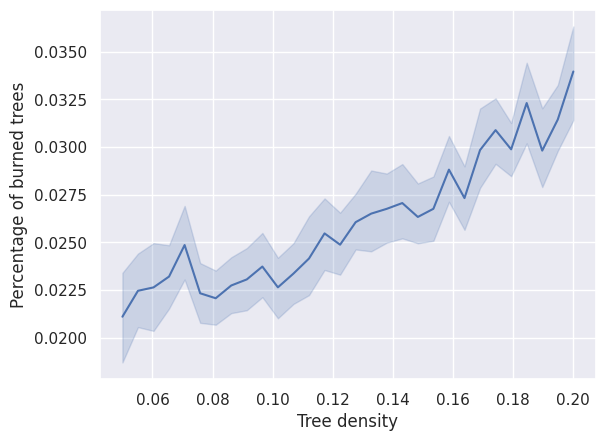

In [9]:
# Plot sensitivity
sns.set_theme()
sns.lineplot(
    data=results.arrange_reporters(), #results.reporters holds data; arrange_reporters() formats it with the parameters
    x='Tree density',
    y='Percentage of burned trees'
);

## Model 2: Flocking behavior

The Boids model is based on two classes, one for the agents, and one for the overall model.
For more information about this structure, take a look at the [creating models](https://agentpy.readthedocs.io/en/latest/overview.html#creating-models).

Each agent starts with a random position and velocity, which are implemented as numpy [arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html).
The position is defined through the space environment,
which the agent can access via `Agent.position()` and `Agent.neighbors()`.

The methods `update_velocity()` and `update_position()` are separated so that all agents can
update their velocity before the actual movement takes place.
For more information about the algorithm in `update_velocity()`,
check out the [Boids Pseudocode](http://www.vergenet.net/~conrad/boids/pseudocode.html).

In [10]:
def normalize(v):
    """ Normalize a vector to length 1. """
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [11]:
class Boid(ap.Agent):
    """ An agent with a position and velocity in a continuous space,
    who follows Craig Reynolds three rules of flocking behavior;
    plus a fourth rule to avoid the edges of the simulation space. """

    def setup(self):

        self.velocity = normalize(
            self.model.nprandom.random(self.p.ndim) - 0.5)

    def setup_pos(self, space):

        self.space = space
        self.neighbors = space.neighbors
        self.pos = space.positions[self]

    def update_velocity(self):

        pos = self.pos
        ndim = self.p.ndim

        # Rule 1 - Cohesion
        nbs = self.neighbors(self, distance=self.p.outer_radius)
        nbs_len = len(nbs)
        nbs_pos_array = np.array(nbs.pos)
        nbs_vec_array = np.array(nbs.velocity)
        if nbs_len > 0:
            center = np.sum(nbs_pos_array, 0) / nbs_len
            v1 = (center - pos) * self.p.cohesion_strength
        else:
            v1 = np.zeros(ndim)

        # Rule 2 - Seperation
        v2 = np.zeros(ndim)
        for nb in self.neighbors(self, distance=self.p.inner_radius):
            v2 -= nb.pos - pos
        v2 *= self.p.seperation_strength

        # Rule 3 - Alignment
        if nbs_len > 0:
            average_v = np.sum(nbs_vec_array, 0) / nbs_len
            v3 = (average_v - self.velocity) * self.p.alignment_strength
        else:
            v3 = np.zeros(ndim)

        # Rule 4 - Borders
        v4 = np.zeros(ndim)
        d = self.p.border_distance
        s = self.p.border_strength
        for i in range(ndim):
            if pos[i] < d:
                v4[i] += s
            elif pos[i] > self.space.shape[i] - d:
                v4[i] -= s

        # Update velocity
        self.velocity += v1 + v2 + v3 + v4
        self.velocity = normalize(self.velocity)

    def update_position(self):

        self.space.move_by(self, self.velocity)

In [12]:
class BoidsModel(ap.Model):
    """
    An agent-based model of animals' flocking behavior,
    based on Craig Reynolds' Boids Model [1]
    and Conrad Parkers' Boids Pseudocode [2].

    [1] http://www.red3d.com/cwr/boids/
    [2] http://www.vergenet.net/~conrad/boids/pseudocode.html
    """

    def setup(self):
        """ Initializes the agents and network of the model. """

        self.space = ap.Space(self, shape=[self.p.size]*self.p.ndim)
        self.agents = ap.AgentList(self, self.p.population, Boid)
        self.space.add_agents(self.agents, random=True)
        self.agents.setup_pos(self.space)

    def step(self):
        """ Defines the models' events per simulation step. """

        self.agents.update_velocity()  # Adjust direction
        self.agents.update_position()  # Move into new direction

### Visualization functions

Next, we define a plot function that can take our model and parameters as an input and creates an animated plot with `animate()`:

In [13]:
def animation_plot_single(m, ax):
    ndim = m.p.ndim
    ax.set_title(f"Boids Flocking Model {ndim}D t={m.t}")
    pos = m.space.positions.values()
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=1, c='black')
    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    if ndim == 3:
        ax.set_zlim(0, m.p.size)
    ax.set_axis_off()

def animation_plot(m, p):
    projection = '3d' if p['ndim'] == 3 else None
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection=projection)
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    return IPython.display.HTML(animation.to_jshtml(fps=20))

### Simulation (2D)

To run a simulation, we define a dictionary with our parameters:

In [14]:
#These parameters make all the boids go into the upper right corner.
#parameters2D = {
#   'size': 20,
#   'seed': 234,
#   'steps': 100,
#   'ndim': 2,
#   'population': 300,
#  'inner_radius': .002,
#   'outer_radius': 2,
#  'border_distance': 60,
#  'cohesion_strength': 0.005,
#   'seperation_strength': 5.0,
#   'alignment_strength': 0.3,
#  'border_strength': 2.0
#}

In [15]:
# These boids cluster together to look like crawling bugs
#parameters2D = {
#    'size': 50,
#    'seed': 365,
#    'steps': 1000,
#    'ndim': 2,
#    'population': 500,
#    'inner_radius': 15,
#   'outer_radius': 3,
#    'border_distance': 10,
#    'cohesion_strength': 0.02,
#    'seperation_strength': 0.03,
#    'alignment_strength': 0.7,
#    'border_strength': 0.5
#}

In [34]:
parameters2D = {
    'size': 100,
    'seed': 555,
    'steps': 200,
    'ndim': 2,
    'population': 500,
    'inner_radius': 5,
    'outer_radius': 10,
    'border_distance': 8,
    'cohesion_strength': 0.005,
    'seperation_strength': 0.05,
    'alignment_strength': 0.25,
    'border_strength': 2.5
}

We can now display our first animation with two dimensions:

In [35]:
animation_plot(BoidsModel, parameters2D)

Output hidden; open in https://colab.research.google.com to view.

### Simulation (3D)

With three dimensions, use a larger number of agents, and more space:

In [36]:
new_parameters = {
    'ndim': 3,
    'population': 1000,
}

parameters3D = dict(parameters2D)
parameters3D.update(new_parameters)

animation_plot(BoidsModel, parameters3D)

# Agent-based modeling II: Bacterial growth models 10/17

Let's build some models with chagpt!

For this section, we will just use numpy to manually make a 2D grid, and then we will seed bacteria to grow in the space we provide.

In the second portion, I asked chatgpt to add some specific processes that I think bring the growth closer to reality and increase its stochasticity.

### Tasks for this section:

1. For this section, try adding your own NEW agent behaviour (I would give the model to chat gpt and see what it gives you as a template).

2. Then, perform a parameter sweep like we did on Tuesday to answer some some question (e.g., what range of death rate stops the cells from filling the space?)
    Again, chatgpt is your friend as a template.

### Simple model of bacterial growth in 2D space

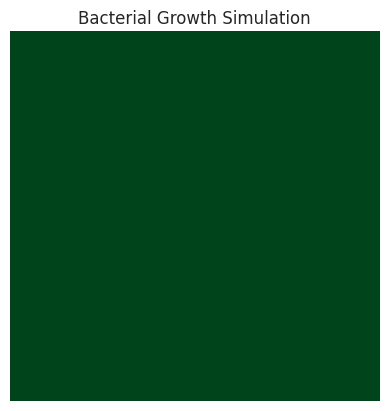

In [19]:
# Use this for inline plots in VS Code's Jupyter notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Parameters
grid_size = 50        # Size of the grid (50x50)
max_steps = 50      # Maximum number of steps for the simulation
initial_position = (grid_size // 2, grid_size // 2)  # Starting at the center

# Initialize the grid with zeros
grid = np.zeros((grid_size, grid_size), dtype=int)
grid[initial_position] = 1  # Place the initial bacterium at the center

# Define directions including diagonals
directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
              (-1, -1), (-1, 1), (1, -1), (1, 1)]

def get_empty_neighbors(grid, x, y):
    """Return a list of empty neighboring cells for a given position."""
    neighbors = []
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 <= nx < grid_size and 0 <= ny < grid_size and grid[nx, ny] == 0:
            neighbors.append((nx, ny))
    return neighbors

def update_grid(grid):
    """Update the grid by allowing each bacterium to divide into one neighboring cell."""
    new_grid = grid.copy()  # Create a copy to hold updates
    bacteria_positions = list(zip(*np.where(grid == 1)))  # List of (x, y) tuples where bacteria are present
    np.random.shuffle(bacteria_positions)  # Shuffle to randomize growth direction

    for x, y in bacteria_positions:
        empty_neighbors = get_empty_neighbors(grid, x, y)
        if empty_neighbors:
            # Randomly select an empty neighbor to grow into
            nx, ny = empty_neighbors[np.random.randint(len(empty_neighbors))]
            new_grid[nx, ny] = 1  # Grow into the empty neighboring cell

    return new_grid

# Set up the plot
fig, ax = plt.subplots()
img = ax.imshow(grid, cmap='Greens', interpolation='nearest', vmin=0, vmax=1)
ax.set_title('Bacterial Growth Simulation')
ax.axis('off')  # Hide the axes for better visualization

def animate(frame):
    """Function to update the animation at each frame."""
    global grid
    grid = update_grid(grid)
    img.set_data(grid)
    return [img]

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=max_steps, interval=50, blit=True, repeat=False)

# Display the animation as HTML in the notebook
HTML(ani.to_jshtml())


### Bacterial growth simulation including nutrient limitation and death

In [20]:
# Use this for inline plots in VS Code's Jupyter notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Parameters
grid_size = 50        # Size of the grid (50x50)
max_steps = 200      # Maximum number of steps for the simulation
initial_position = (grid_size // 2, grid_size // 2)  # Starting at the center
growth_probability = 0.5  # Probability that a bacterium divides
death_probability = 0.01  # Probability that a bacterium dies
initial_nutrient = 100  # Initial nutrient level

# Initialize the grid with zeros and nutrient levels
grid = np.zeros((grid_size, grid_size), dtype=int)
nutrient_grid = np.full((grid_size, grid_size), initial_nutrient)  # Grid of nutrients
grid[initial_position] = 1  # Place the initial bacterium at the center

# Track the number of live cells at each time step
live_cells_count = []

# Define directions including diagonals
directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
              (-1, -1), (-1, 1), (1, -1), (1, 1)]

def get_empty_neighbors(grid, x, y):
    """Return a list of empty neighboring cells for a given position."""
    neighbors = []
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 <= nx < grid_size and 0 <= ny < grid_size and grid[nx, ny] == 0:
            neighbors.append((nx, ny))
    return neighbors

def update_grid(grid, nutrient_grid):
    """Update the grid by allowing each bacterium to divide into one neighboring cell or die."""
    new_grid = grid.copy()  # Create a copy to hold updates
    bacteria_positions = list(zip(*np.where(grid == 1)))  # List of (x, y) tuples where bacteria are present
    np.random.shuffle(bacteria_positions)  # Shuffle to randomize growth direction

    for x, y in bacteria_positions:
        # Each bacterium consumes nutrients from its location
        nutrient_grid[x, y] -= 1

        # Bacteria die with a probability if nutrients are too low
        if np.random.rand() < death_probability or nutrient_grid[x, y] <= 0:
            new_grid[x, y] = 0  # Bacterium dies
            continue

        # Bacteria divide with a certain probability if there are empty neighbors
        empty_neighbors = get_empty_neighbors(grid, x, y)
        if empty_neighbors and np.random.rand() < growth_probability:
            nx, ny = empty_neighbors[np.random.randint(len(empty_neighbors))]
            new_grid[nx, ny] = 1  # Grow into the empty neighboring cell

    return new_grid, nutrient_grid

# Set up the plot
fig, ax = plt.subplots()
img = ax.imshow(grid, cmap='Greens', interpolation='nearest', vmin=0, vmax=1)
ax.set_title('Bacterial Growth Simulation with Nutrient Limitation and Death')
ax.axis('off')  # Hide the axes for better visualization

def animate(frame):
    """Function to update the animation at each frame."""
    global grid, nutrient_grid
    grid, nutrient_grid = update_grid(grid, nutrient_grid)

    # Count live cells and store the count for each time step
    live_cells = np.sum(grid)
    live_cells_count.append(live_cells)

    img.set_data(grid)
    return [img]

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=max_steps, interval=100, blit=True, repeat=False)

# Display the animation as HTML in the notebook
HTML(ani.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

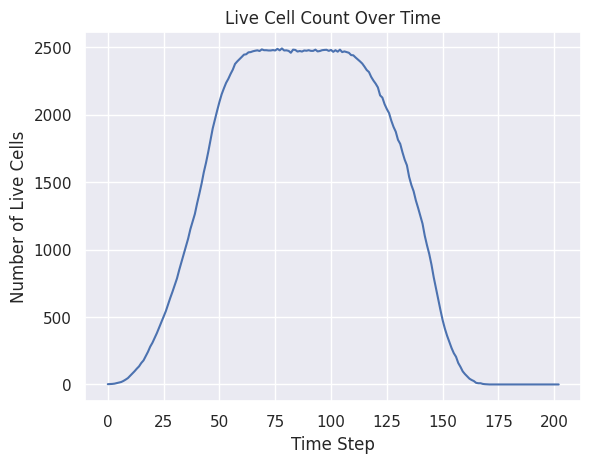

In [21]:
# Plot live cell count vs time after the animation
plt.figure()
plt.plot(live_cells_count)
plt.title("Live Cell Count Over Time")
plt.xlabel("Time Step")
plt.ylabel("Number of Live Cells")
plt.show()


### Add a new agent behaviour and perform a parameter sweep below:

In [22]:
# Electrical Pulse Across Neurons
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Parameters
grid_size = 50        # Size of the grid (50x50)
max_steps = 200       # Maximum number of steps for the simulation
initial_activation = (grid_size // 2, grid_size // 2)  # Starting activation at the center
activation_threshold = 1  # Threshold for a neuron to activate
recovery_time = 20    # Steps required for neurons to recover (refractory period)
propagation_probability = 0.5  # Probability of pulse propagation to neighbors

# State grids
neuron_grid = np.zeros((grid_size, grid_size), dtype=int)  # Neuron activation state: 0=rest, 1=active, -1=refractory
refractory_timer = np.zeros((grid_size, grid_size), dtype=int)  # Timer for refractory periods

# Initialize the first active neuron in the center
neuron_grid[initial_activation] = 1  # Initial activation

# Define directions including diagonals for potential pulse propagation
directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
              (-1, -1), (-1, 1), (1, -1), (1, 1)]

def get_neighboring_neurons(grid, x, y):
    """Return a list of neighboring neuron positions for a given neuron."""
    neighbors = []
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 <= nx < grid_size and 0 <= ny < grid_size:
            neighbors.append((nx, ny))
    return neighbors

def update_neuron_states(neuron_grid, refractory_timer):
    """Update neuron states: propagate pulses, handle activation, and recovery."""
    new_grid = neuron_grid.copy()

    # Iterate through the grid to propagate pulses and manage neuron states
    for x in range(grid_size):
        for y in range(grid_size):
            if neuron_grid[x, y] == 1:  # Active neuron, propagate pulse
                neighbors = get_neighboring_neurons(neuron_grid, x, y)
                for nx, ny in neighbors:
                    if neuron_grid[nx, ny] == 0 and np.random.rand() < propagation_probability:
                        new_grid[nx, ny] = 1  # Neighboring neuron gets activated

                # Set the current neuron to refractory state
                new_grid[x, y] = -1
                refractory_timer[x, y] = recovery_time

            elif neuron_grid[x, y] == -1:  # Neuron in refractory state
                refractory_timer[x, y] -= 1
                if refractory_timer[x, y] <= 0:
                    new_grid[x, y] = 0  # Neuron recovers to resting state

    return new_grid, refractory_timer

# Set up the plot
fig, ax = plt.subplots()
img = ax.imshow(neuron_grid, cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
ax.set_title('Electrical Pulse Propagation in Neuron Cluster')
ax.axis('off')  # Hide the axes for better visualization

def animate(frame):
    """Function to update the animation at each frame."""
    global neuron_grid, refractory_timer
    neuron_grid, refractory_timer = update_neuron_states(neuron_grid, refractory_timer)

    img.set_data(neuron_grid)
    return [img]

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=max_steps, interval=100, blit=True, repeat=False)

# Display the animation as HTML in the notebook
HTML(ani.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

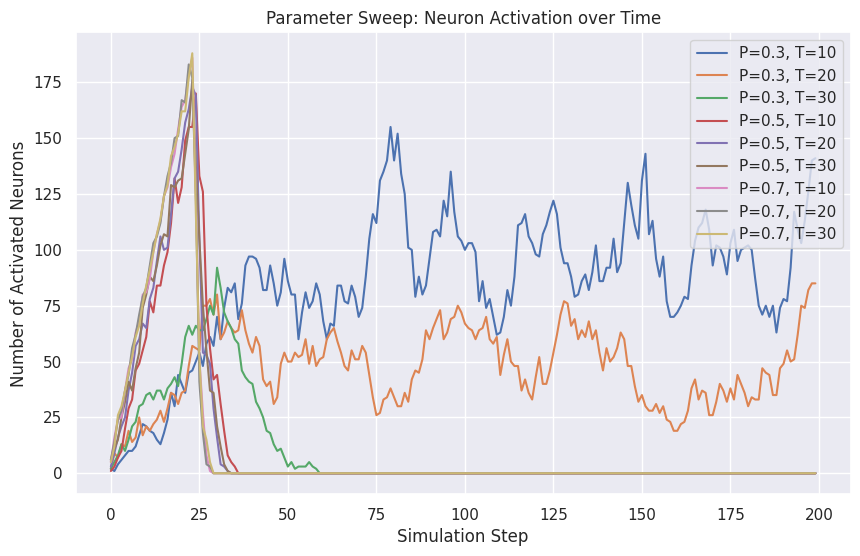

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Parameters
grid_size = 50        # Size of the grid (50x50)
max_steps = 200       # Maximum number of steps for the simulation
initial_activation = (grid_size // 2, grid_size // 2)  # Starting activation at the center
activation_threshold = 1  # Threshold for a neuron to activate

# Parameter sweep ranges
propagation_probabilities = [0.3, 0.5, 0.7]  # Range of propagation probabilities to test
recovery_times = [10, 20, 30]  # Range of recovery times to test

# Results storage
sweep_results = {}

def run_simulation(propagation_probability, recovery_time):
    """Run the neuron pulse simulation with specific parameters."""

    # Initialize state grids
    neuron_grid = np.zeros((grid_size, grid_size), dtype=int)  # Neuron activation state: 0=rest, 1=active, -1=refractory
    refractory_timer = np.zeros((grid_size, grid_size), dtype=int)  # Timer for refractory periods

    # Initialize the first active neuron in the center
    neuron_grid[initial_activation] = 1  # Initial activation

    # Define directions including diagonals for potential pulse propagation
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]

    def get_neighboring_neurons(grid, x, y):
        """Return a list of neighboring neuron positions for a given neuron."""
        neighbors = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                neighbors.append((nx, ny))
        return neighbors

    def update_neuron_states(neuron_grid, refractory_timer):
        """Update neuron states: propagate pulses, handle activation, and recovery."""
        new_grid = neuron_grid.copy()

        # Iterate through the grid to propagate pulses and manage neuron states
        for x in range(grid_size):
            for y in range(grid_size):
                if neuron_grid[x, y] == 1:  # Active neuron, propagate pulse
                    neighbors = get_neighboring_neurons(neuron_grid, x, y)
                    for nx, ny in neighbors:
                        if neuron_grid[nx, ny] == 0 and np.random.rand() < propagation_probability:
                            new_grid[nx, ny] = 1  # Neighboring neuron gets activated

                    # Set the current neuron to refractory state
                    new_grid[x, y] = -1
                    refractory_timer[x, y] = recovery_time

                elif neuron_grid[x, y] == -1:  # Neuron in refractory state
                    refractory_timer[x, y] -= 1
                    if refractory_timer[x, y] <= 0:
                        new_grid[x, y] = 0  # Neuron recovers to resting state

        return new_grid, refractory_timer

    # Track the number of activated neurons at each time step
    activated_neurons_count = []

    for step in range(max_steps):
        neuron_grid, refractory_timer = update_neuron_states(neuron_grid, refractory_timer)
        activated_neurons = np.sum(neuron_grid == 1)  # Count active neurons
        activated_neurons_count.append(activated_neurons)

    return activated_neurons_count

# Run parameter sweep
for propagation_probability in propagation_probabilities:
    for recovery_time in recovery_times:
        # Run the simulation for this parameter combination
        activated_neurons_count = run_simulation(propagation_probability, recovery_time)

        # Store the result
        sweep_results[(propagation_probability, recovery_time)] = activated_neurons_count

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

for (propagation_probability, recovery_time), result in sweep_results.items():
    ax.plot(result, label=f'P={propagation_probability}, T={recovery_time}')

ax.set_xlabel('Simulation Step')
ax.set_ylabel('Number of Activated Neurons')
ax.set_title('Parameter Sweep: Neuron Activation over Time')
ax.legend()
plt.show()
